In [ ]:
# default_exp subcoco_pl

# Exploring Object Detection using Pytorch Lightning Only

Instead of using higher level library such as IceVision, I am gonna try using what's in Torch Vision, see [example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

To force some learning, I shall attempt to port the example to [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning) as it removes a lot of boiler plate code and standardized Pytorch usage. It also makes advanced features like gradient accumulation and multi-GPU multi-node training simple.

In [ ]:
#export
import json, os, requests, sys, tarfile, torch, torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import pytorch_lightning as pl
import torch.nn.functional as F

from collections import defaultdict
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, TrainResult

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm

from mcbbox.subcoco_utils import *

/usr/local/lib/python3.8/dist-packages/graphql/type/typemap.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Sequence, defaultdict


In [ ]:
#hide
from nbdev.showdoc import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/brian/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, pytorch_lightning 1.0.3


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

In [ ]:
datadir = Path("workspace")

froot = "coco_sample"
fname = f"{froot}.tgz"
url = f"https://s3.amazonaws.com/fast-ai-coco/{fname}"
json_fname = datadir/froot/'annotations'/'train_sample.json'
img_dir = datadir/froot/'train_sample'

if not os.path.isdir(datadir/froot): 
    fetch_data(url, datadir, fname, chunk_size=1024*1024)

## Check Annotations

Let's load and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
with open(json_fname, 'r') as json_f:
    train_json = json.load(json_f)
    
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 318219, 'file_name': '000000318219.jpg'},
 [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image...

In [ ]:
stats = load_stats(train_json, img_dir=img_dir, force_reload=False) 
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
{ stats.cat2name[stats.lbl2cat[lid]]: len(ibs) for lid, ibs in stats.l2ibs.items()}

Categories 6, Images 21837, Boxes 87106, avg (w,h) (575.6857626963424, 481.71420066859)avg cats/img 7.0, avg boxs/img 4.0, avg boxs/cat 14517.7.
Image means by channel [115.64436835 103.2992867   91.73613059], std.dev by channel [64.16724017 62.63021182 61.92975836]


{'tv': 5805,
 'book': 24715,
 'chair': 38491,
 'vase': 6613,
 'remote': 5703,
 'couch': 5779}

Print out number of boxes per category to see if the distribution is not too unbalanced...

Hmm, seems like a lot of chairs and books, but vases, tvs, couches and remotes are roughly 10x less. This may be a problem. 
But we have enough to test drive the training pipeline. To make it more balanced, may be I can combine vase+tv+couch+remote into a new category 'others' later?

## Look at Images

Let's look at an image annotation.

In [ ]:
img_pos = 256
img_id = train_json['images'][img_pos]['id']
l2bs = stats.img2l2bs[img_id]
img_fname = stats.img2fname[img_id]
img_id, img_fname, l2bs

(425870,
 '000000425870.jpg',
 {0: [],
  1: [],
  2: [],
  3: [(342.29, 79.46, 137.71, 192.72)],
  4: [(218.85, 309.35, 29.2, 38.71)],
  5: [(167.22, 246.04, 53.41, 43.17),
   (267.69, 280.18, 35.51, 75.55),
   (130.34, 224.03, 42.99, 61.49),
   (187.69, 250.21, 38.82, 19.17)],
  6: []})

## Overlay Boxes and Labels from Annotation

Let's overlay bounding boxes and labels over the image to confirm our understanding of the data.

Pick some random image to test drive the box overlay code...

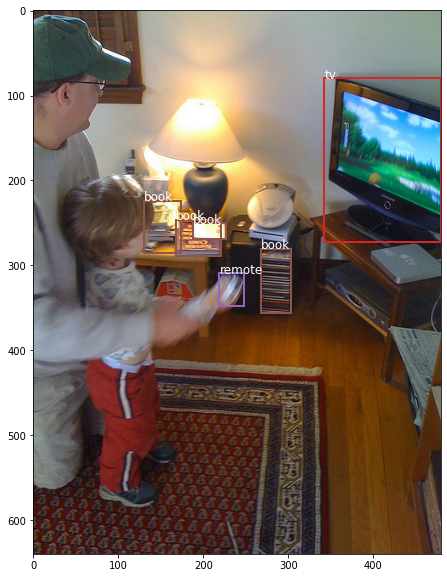

In [ ]:
img = Image.open(img_dir/stats.img2fname[img_id])
overlay_img_bbox(img, stats.img2l2bs[img_id], stats.lbl2name)

Looks good enough. Now wrap the Dataset into a DataModule...

In [ ]:
subcoco_dm = SubCocoDataModule(img_dir, stats, bs=8) # max for GTX-1050 4GB VRAM w/ img 384x384
tdl=subcoco_dm.train_dataloader()
images, targets = next(iter(tdl))
len(images), len(targets)

(8, 8)

## Neural Network Architecture Model

In [ ]:
frcnn_model = FRCNN(lbl2name=stats.lbl2name)

On my Dell XPS15 GTX-1050 GPU w/ 4GB VRAM,  I can average 1 epoc every 90 min or so, at bs=8, acc=4, img 384x384.

Using my GCP w/ V100 of 16GB VRAM, I can fit bs=32 for sample_coco. No need for gradient accumulation!
From earlier experimentation, I can average 1 epoc every 20 minutes or so, let's go for 30 epocs...

In [ ]:
chkpt_cb = ModelCheckpoint(
    filepath="models/FRCNN-"+froot+"-{epoch}-{val_acc:.2f}.ckpt",
    save_last=True,
    monitor='val_acc',
    mode='max',
    verbose=True,
)
# train
trainer = Trainer(gpus=1, max_epochs=1, checkpoint_callback=chkpt_cb, accumulate_grad_batches=4) # my DM bs=8 tiny!
trainer.fit(frcnn_model, subcoco_dm)

GPU available: True, used: True
GPU available: True, used: True
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
CUDA_VISIBLE_DEVICES: [0]
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


/home/brian/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: 
                    When using EvalResult(early_stop_on=X) or TrainResult(early_stop_on=X) the
                    'monitor' key of ModelCheckpoint has no effect.
                    Remove ModelCheckpoint(monitor='val_acc) to fix')
                
  warnings.warn(*args, **kwargs)
/home/brian/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned 0.0 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_acc in validation_epoch_end()?
  warnings.warn(*args, **kwargs)

Epoch 00000: val_acc reached 0.00000 (best 0.00000), saving model to /home/brian/Projects/mcbbox/models/FRCNN-coco_sample-epoch=0-val_acc=0.00.ckpt.ckpt as top 1

Epoch 00000: val_acc reached 0.00000 (best 0.00000), saving model to /home/brian/Projects/mcbbox/models/FRCNN-coco_sample-epoch=0-val_acc=0.00.ckpt.ckpt as 

1

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --host "0.0.0.0" 

## Inference

Time to see how well the model can perform.

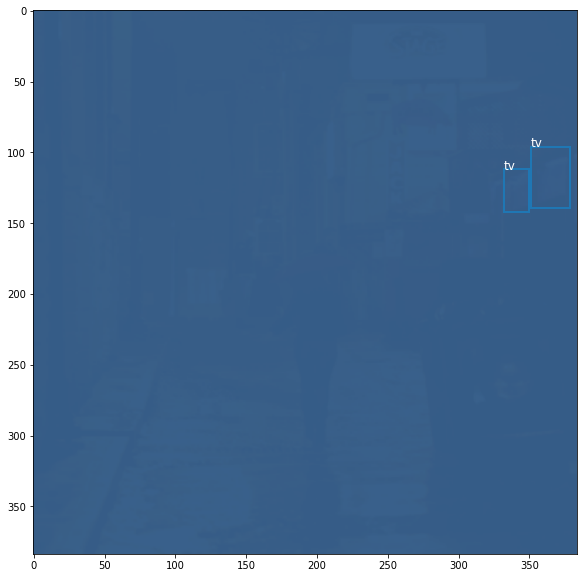

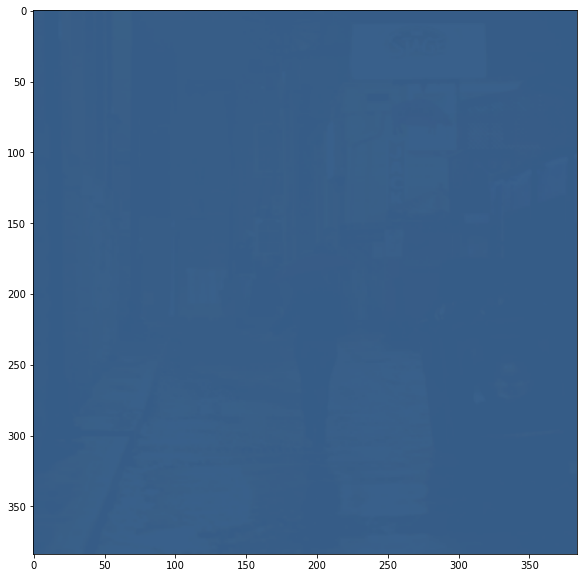

In [ ]:
x = images[0]
y = targets[0]
pimg = torchvision.transforms.ToPILImage()(x)
tgt_l2bs = defaultdict(empty_list)
for l, b in zip(list(y['labels']), y['boxes']):
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 
           
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

frcnn_model.eval()
pred = frcnn_model([x])
pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=0.5)
overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

Compare with Original Image before transformations incl. Normalization and Resize.

(array([0.45350733, 0.40509524, 0.35974953]),
 array([0.25163624, 0.24560867, 0.2428618 ]))

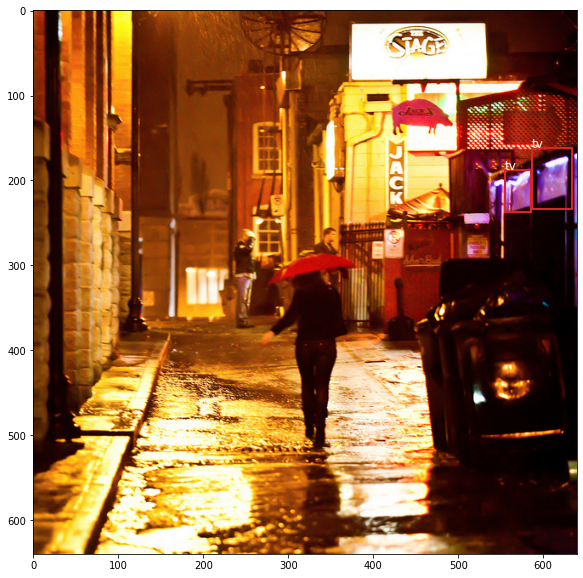

In [ ]:
img_id = int(y['image_id'])
img = Image.open(img_dir/stats.img2fname[img_id])
overlay_img_bbox(img, stats.img2l2bs[img_id], stats.lbl2name)
stats.chn_means/255, stats.chn_stds/255

## Saving and Reloading using Underlying Pytorch (Lightning Saving still has bug)

In [ ]:
model_save_path = f"models/FRCNN-{froot}-final.saved"
torch.save(frcnn_model.model.state_dict(), model_save_path)

In [ ]:
pretrained_model = FRCNN(lbl2name=stats.lbl2name)
pretrained_model.model.load_state_dict(torch.load(model_save_path))
pretrained_model.freeze()

In [ ]:
pred = pretrained_model([img[0]])
pred_l2bs = digest_pred(stats.lbl2name, pred[0])
pimg = torchvision.transforms.ToPILImage()(img[0])

overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

# Code to Run in Python Standalone Script

In [ ]:
#export
if __name__ == "__main__" and not is_notebook():
    projroot = Path.home()/"Projects"/"mcbbox"
    datadir = projroot/"workspace"
    froot = "coco_sample"
    fname = f"{froot}.tgz"
    url = f"https://s3.amazonaws.com/fast-ai-coco/{fname}"
    json_fname = datadir/froot/'annotations'/'train_sample.json'
    img_dir = datadir/froot/'train_sample'
    if not os.path.isdir(datadir/froot): 
        fetch_data(url, datadir, fname, chunk_size=1024*1024)
    with open(json_fname, 'r') as json_f:
        train_json = json.load(json_f)
    stats = load_stats(train_json, img_dir=img_dir)
    
    subcoco_dm = SubCocoDataModule(img_dir, stats, bs=16)
    tdl=subcoco_dm.train_dataloader()
    frcnn_model = FRCNN(lbl2name=stats.lbl2name)
    save_model_fname=f'standalone-FRCNN-subcoco-{size}'
    chkpt_cb = ModelCheckpoint(
        filepath=f"{projroot}/models/{save_model_fname}.ckpt",
        save_last=False,
        monitor='val_acc',
        mode='max'
    )
    trainer = Trainer(gpus=1, max_epochs=1, checkpoint_callback=chkpt_cb, accumulate_grad_batches=2)
    trainer.fit(frcnn_model, subcoco_dm)
    model_save_path = projroot/"models"/f"{save_model_fname}-final.saved"
    torch.save(frcnn_model.model.state_dict(), model_save_path)